# MTG Card Data Analysis

## Objective

The objective of this notebook is to take a structured look at various elements of the corpus of Magic the Gathering cards created over the game's lifetime. I want to understand trends and generate data driven insights that help me understand how the game is changing and evolving over time.

### Index

* [Required Imports](#req_imports)
* [Load Data](#load_data)
* [Charts and Tables](#charts-and-tables)

<a id="req_imports"></a>
### Required imports

In [14]:
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


<div class="alert alert-block alert-info">
<b>NB:</b> Optionally you can edit the theme of the graphs using seaborn. Adjustments here will be made globally.</div>

In [15]:
sns.set_theme()
sns.set_context("poster")

### Load Data
<a id="load_data"></a>
There are two bulk data sets provided by scryfall

```
oracle-cards-***.json
default-cards-***.json
```

Both are valid datasets to analyze. I have chosen to analyze the default cards as it is the fuller of the two datasets containing every single card ever printed by WOTC rather than the `oracle-cards.json` that only contains one printing per card.


In [16]:
#df = pd.read_json('oracle-cards-20231030210222.json')
df= pd.read_json('default-cards-20231030211106.json')

##### Filters

It is important to filter this database so that i can control the data i am examining.

There are a wide number of sets on scryfall that i am not interested in.

I exclude any set with the below keywords in its name:

```
[
    "token", "playtest", "scheme", "planechase", "sticker", "art series", "alchemy", "anthology"
]
```

I also do not want to include unsets in my analysis so they are excluded.

2024 Data is temporarily excluded as, as of today, the full spoilers are not available and it is a distorting element on any predictive analytics.

In [17]:
# Keywords to exclude
excluded_keywords = ["token", "playtest", "scheme", "planechase", "sticker", "art series", "alchemy", "anthology"]

# Filter out sets based on keywords
df = df[~df['set_name'].str.lower().str.contains('|'.join(excluded_keywords))]

# Handle NaN values in 'oracle_text'
df['oracle_text'] = df['oracle_text'].fillna('')

# Remove sets with fewer than 30 cards
#filtered_sets = df['set_name'].value_counts()
#valid_sets = filtered_sets[filtered_sets >= 30].index
#df = df[df['set_name'].isin(valid_sets)]

# Filtering out rows where set_name starts with "un" (case-insensitive)
df = df[~df['set_name'].str.lower().str.startswith('un')]

# Assuming 'released_at' is a string representing dates, convert to datetime
df['released_at'] = pd.to_datetime(df['released_at'], errors='coerce')

# Drop rows with NaT in 'released_at' if any conversion errors occurred
df = df.dropna(subset=['released_at'])

# Extract year from 'released_at' datetime column
df['release_year'] = df['released_at'].dt.year

# Filter out all data from 2024
df = df[df['release_year'] != 2024]

### Charts and Tables

<a id="charts_and_tables"></a> 

Finally the meat and potatoes of the whole endeavour.

#### Wordcloud

Just for fun generate a wordcloud of all of the words on magic cards since the first year

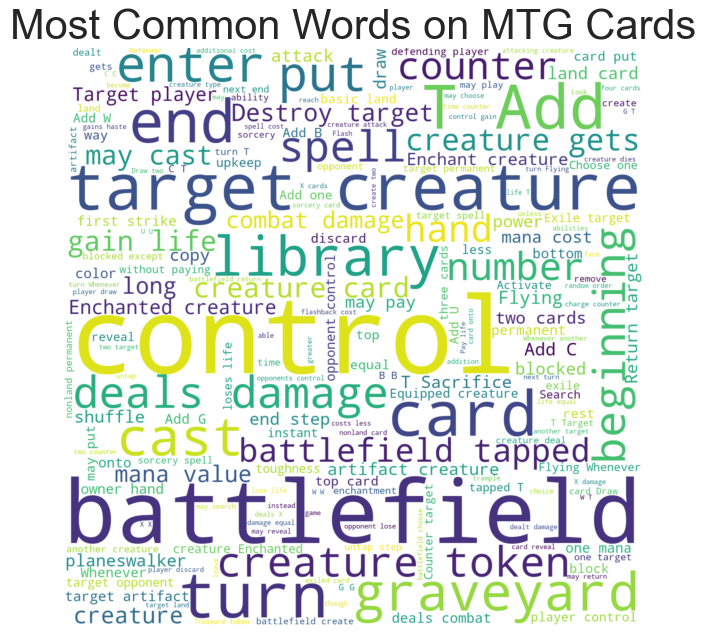

In [18]:
# Combine all oracle texts into one large string
all_text = ' '.join(df['oracle_text'].tolist())

# Generate a word cloud image
wordcloud = WordCloud(width=1600, height=1600, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Most Common Words on MTG Cards', fontsize=30)
plt.show()


### Some aggregate bar charts

Question - What is the average wordcount of sets released per year and how many NEW cards are released?

Method - Filter out any cards with the same name but a later release date to remove the reprints. Includes a trend line for wordiness

In this graph I can see that the average word count of new MTG cards has remained consistent throughout the years with a clearly defined upward trend. The number of unique new cards has exploded since 2018 to be consistently well in excess of 1500 new cards per year. This beats previous years by at least 200% in many cases

C:\Users\edwar\AppData\Local\Temp\ipykernel_15212\3139117004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['year'] = df_unique['released_at'].dt.year


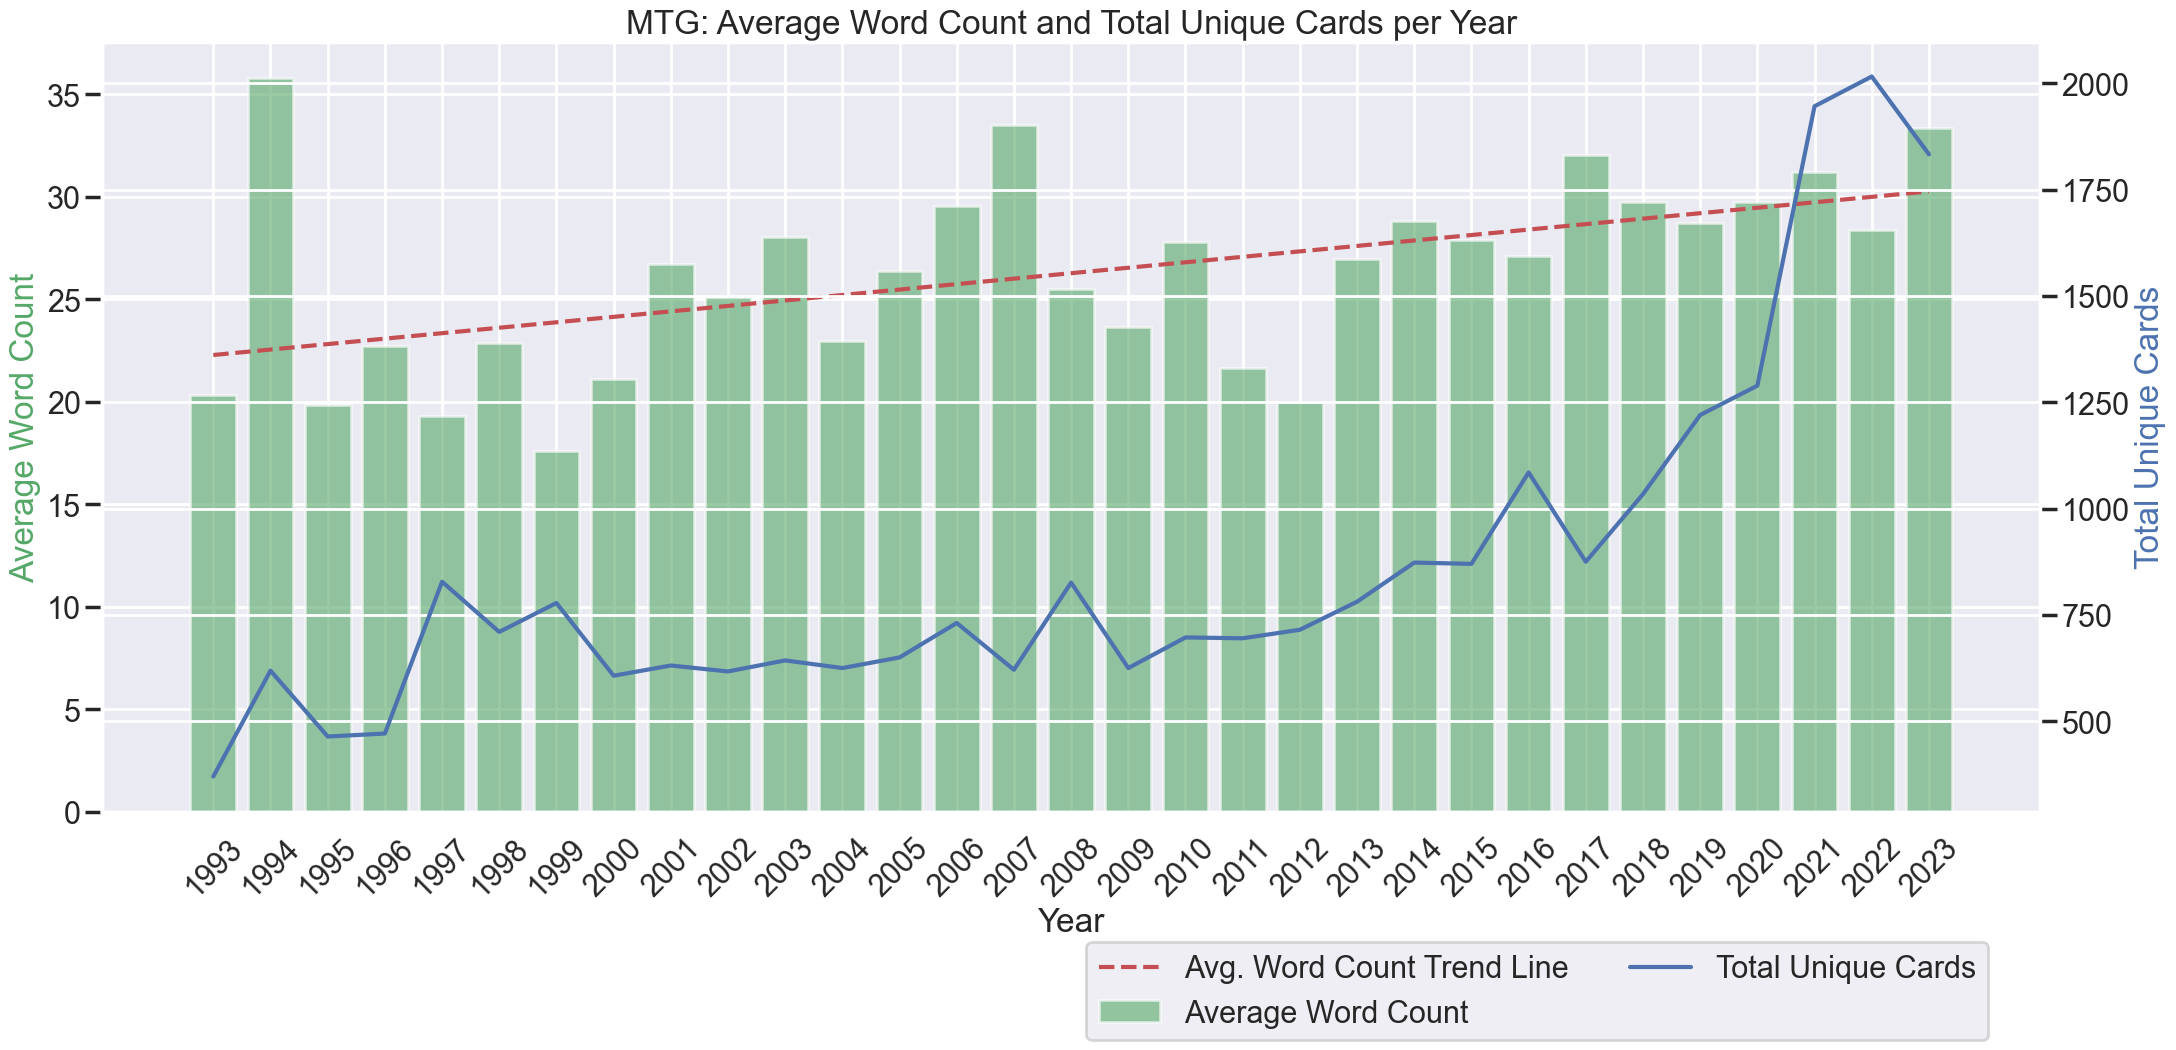

In [19]:
# Sort by 'name' and 'released_at' so that the earliest print of a card is first
df = df.sort_values(by=['name', 'released_at'])

# Drop duplicates keeping the first occurrence (which is the earliest release of a card)
df_unique = df.drop_duplicates(subset='name', keep='first')

# Create a year column for grouping
df_unique['year'] = df_unique['released_at'].dt.year

# Calculate average word count per set per year
avg_word_count = df_unique.groupby(['set_name', 'year'])['oracle_text'].apply(lambda x: x.str.split().str.len().mean()).reset_index(name='average_word_count')

# Calculate total number of unique new cards released per year
total_unique_cards_yearly = df_unique.groupby('year')['name'].nunique().reset_index(name='total_unique_cards')

# Now for plotting
fig, ax1 = plt.subplots(figsize=(25, 10))

# First component: Average word count (bar graph)
avg_word_count_per_year = avg_word_count.groupby('year')['average_word_count'].mean()
ax1.bar(avg_word_count_per_year.index, avg_word_count_per_year.values, color='g', alpha=0.6, label='Average Word Count')

# Second component: Total unique cards (line graph on secondary axis)
ax2 = ax1.twinx()
ax2.plot(total_unique_cards_yearly['year'], total_unique_cards_yearly['total_unique_cards'], color='b', label='Total Unique Cards')

# Calculate and plot the trend line for average word count
z = np.polyfit(avg_word_count_per_year.index, avg_word_count_per_year.values, 1)
p = np.poly1d(z)
ax1.plot(avg_word_count_per_year.index, p(avg_word_count_per_year.index), "r--", label='Avg. Word Count Trend Line')

# Setting the labels and titles
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count', color='g')
ax2.set_ylabel('Total Unique Cards', color='b')
ax1.set_title('MTG: Average Word Count and Total Unique Cards per Year')

# Adjust x-axis to show every year as an integer
ax1.set_xticks(avg_word_count_per_year.index)
ax1.set_xticklabels(avg_word_count_per_year.index.astype(int), rotation=45)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Customizing legend placement to be under the x-axis
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.show()
plt.close(fig)

This leads me to think about what the future might hold. I have applied a regression to three subsets of the data to try to develop a forward looking set of trends.

The three trends are:

* Using all historic data (Circles)
* Using the last 5 years of historic data (Pentagon)
* Using the last 10 years of historic data (Diamond)

This information shows that the trends across the board are for an increasing rate of change. The shorter the time taken into account by the prediction the greater the predicted values are.

In particular the total number of unique cards released over the last five years pushes aggressively well above 3000 in the next ten years if we use the last five years as a baseline.

I would be wary of drawing long term conclusions from short timelines of data but it is indicative in viewing how much has changed in the near term.

<Figure size 640x480 with 0 Axes>

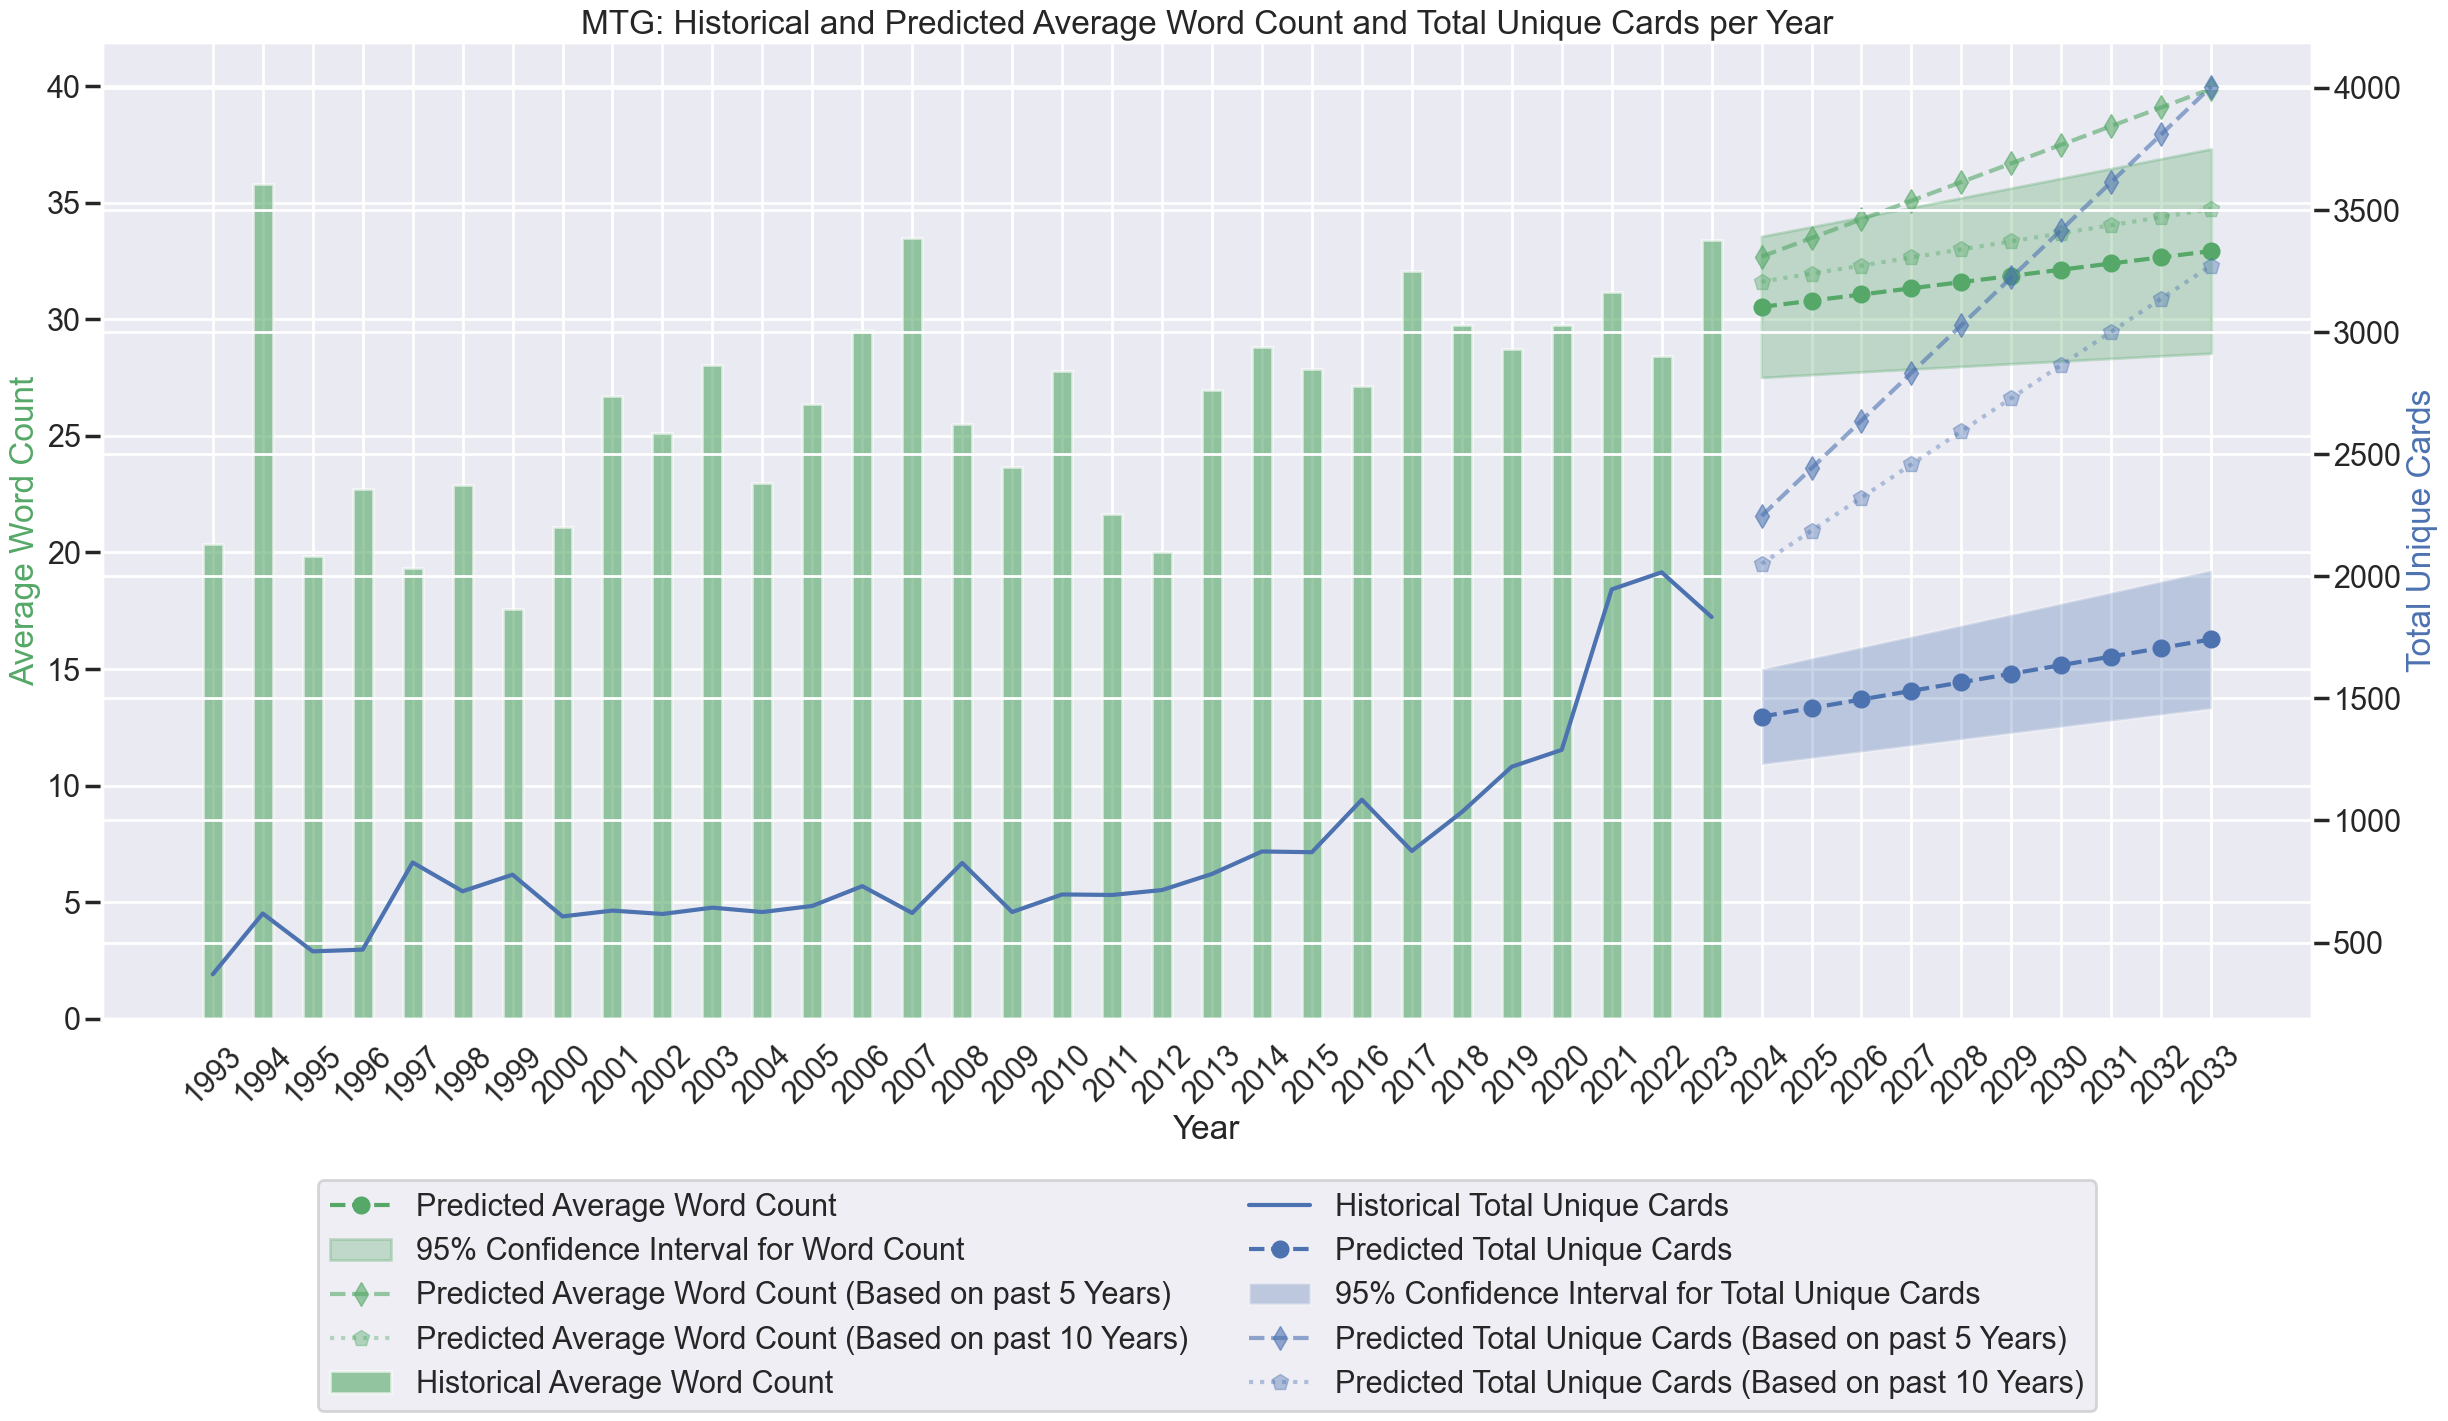

In [20]:
def predict_last_n_years(data, last_n_years, num_years_ahead):
    # Use the last N years for the model
    recent_data = data.tail(last_n_years)
    x_recent = sm.add_constant(recent_data.index)  # Add a constant term for the regression
    
    # Fit the model
    model = sm.OLS(recent_data.values, x_recent).fit()
    
    # Create future year indices for prediction
    predict_years = np.arange(recent_data.index[-1] + 1, recent_data.index[-1] + num_years_ahead + 1)
    x_future = sm.add_constant(predict_years)
    
    # Get predictions
    prediction = model.get_prediction(x_future)
    predicted_mean = prediction.predicted_mean
    predicted_intervals = prediction.conf_int(alpha=0.05)  # 95% confidence intervals
    
    return predict_years, predicted_mean, predicted_intervals, model

# Fit OLS regression models for each dataset

# For average word count data
x_wc = sm.add_constant(avg_word_count_per_year.index)  # x with constant for word count model
model_wc = sm.OLS(avg_word_count_per_year.values, x_wc).fit()

# For total unique cards data
x_uc = sm.add_constant(total_unique_cards_yearly['year'])  # x with constant for unique cards model
model_uc = sm.OLS(total_unique_cards_yearly['total_unique_cards'], x_uc).fit()

# Make predictions for the next ten years
predict_years_wc = np.arange(avg_word_count_per_year.index[-1] + 1, avg_word_count_per_year.index[-1] + 11)
predict_years_uc = np.arange(total_unique_cards_yearly['year'].iloc[-1] + 1, total_unique_cards_yearly['year'].iloc[-1] + 11)

# Prepare the prediction data frames with constants added
x_future_wc = sm.add_constant(predict_years_wc)
x_future_uc = sm.add_constant(predict_years_uc)

# Get predictions
prediction_wc = model_wc.get_prediction(x_future_wc)
predicted_mean_wc = prediction_wc.predicted_mean
predicted_intervals_wc = prediction_wc.conf_int(alpha=0.05)  # 95% confidence intervals for word count

prediction_uc = model_uc.get_prediction(x_future_uc)
predicted_mean_uc = prediction_uc.predicted_mean
predicted_intervals_uc = prediction_uc.conf_int(alpha=0.05)  # 95% confidence intervals for unique cards

# Predictions based on the last 5 and 10 years
num_years_ahead = 10  # Number of years to predict into the future

# For average word count predictions
predict_years_5_wc, predicted_mean_5_wc, predicted_intervals_5_wc, model_5_wc = predict_last_n_years(
    avg_word_count_per_year, 5, num_years_ahead
)

predict_years_10_wc, predicted_mean_10_wc, predicted_intervals_10_wc, model_10_wc = predict_last_n_years(
    avg_word_count_per_year, 10, num_years_ahead
)

# For total unique cards predictions
predict_years_5_uc, predicted_mean_5_uc, predicted_intervals_5_uc, model_5_uc = predict_last_n_years(
    total_unique_cards_yearly.set_index('year')['total_unique_cards'], 5, num_years_ahead
)

predict_years_10_uc, predicted_mean_10_uc, predicted_intervals_10_uc, model_10_uc = predict_last_n_years(
    total_unique_cards_yearly.set_index('year')['total_unique_cards'], 10, num_years_ahead
)


# Plotting
plt.close('all')
plt.clf()
fig, ax1 = plt.subplots(figsize=(25, 15))

# Define ax2 with a shared x-axis and independent y-axis
ax2 = ax1.twinx()

#Define Alphas
all_years_alpha = 1
five_years_alpha = 0.6
ten_years_alpha = 0.4

# Plot historical average word count data and add labels
bars = ax1.bar(avg_word_count_per_year.index, avg_word_count_per_year.values, color='g', alpha=0.6, width=0.4, label='Historical Average Word Count')

# Plot future predictions for average word count with confidence intervals and add labels
ax1.plot(predict_years_wc, predicted_mean_wc, 'go--', label='Predicted Average Word Count', alpha=all_years_alpha)
ax1.fill_between(predict_years_wc, predicted_intervals_wc[:, 0], predicted_intervals_wc[:, 1],color='g', alpha=0.3, label='95% Confidence Interval for Word Count')

#Plot future predictions for average word count 5 years ahead with confidence intervals and add labels
ax1.plot(predict_years_5_wc, predicted_mean_5_wc, 'gd--', label='Predicted Average Word Count (Based on past 5 Years)', alpha=five_years_alpha)
#ax1.fill_between(predict_years_5_wc, predicted_intervals_5_wc[:, 0], predicted_intervals_5_wc[:, 1], color='g', alpha=0.1, label='95% Confidence Interval for Word Count (5 Years)')

#Plot future predictions for average word count 10 years ahead with confidence intervals and add labels
ax1.plot(predict_years_10_wc, predicted_mean_10_wc, 'gp:', label='Predicted Average Word Count (Based on past 10 Years)', alpha=ten_years_alpha)
#ax1.fill_between(predict_years_10_wc, predicted_intervals_10_wc[:, 0], predicted_intervals_10_wc[:, 1], color='g', alpha=0.05, label='95% Confidence Interval for Word Count (10 Years)')

# Plot historical total unique cards data and add labels
ax2.plot(total_unique_cards_yearly['year'], total_unique_cards_yearly['total_unique_cards'], 'b-', label='Historical Total Unique Cards')

# Plotting future predictions for total unique cards
ax2.plot(predict_years_uc, predicted_mean_uc, 'bo--', label='Predicted Total Unique Cards', zorder=5, alpha=all_years_alpha)
ax2.fill_between(predict_years_uc, predicted_intervals_uc[:, 0], predicted_intervals_uc[:, 1], alpha=0.3, label='95% Confidence Interval for Total Unique Cards')

# Plot future predictions for total unique cards 5 years ahead with confidence intervals and add labels
ax2.plot(predict_years_5_uc, predicted_mean_5_uc, 'bd--', label='Predicted Total Unique Cards (Based on past 5 Years)',  alpha=five_years_alpha)
#ax2.fill_between(predict_years_5_uc, predicted_intervals_5_uc[:, 0], predicted_intervals_5_uc[:, 1], color='b', alpha=0.1, label='95% Confidence Interval for Total Unique Cards (5 Years)')

# Plot future predictions for total unique cards 10 years ahead with confidence intervals and add labels
ax2.plot(predict_years_10_uc, predicted_mean_10_uc, 'bp:', label='Predicted Total Unique Cards (Based on past 10 Years)',  alpha=ten_years_alpha)
#ax2.fill_between(predict_years_10_uc, predicted_intervals_10_uc[:, 0], predicted_intervals_10_uc[:, 1], color='b', alpha=0.05, label='95% Confidence Interval for Total Unique Cards (10 Years)')

# Set the labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count', color='g')
ax2.set_ylabel('Total Unique Cards', color='b')
ax1.set_title('MTG: Historical and Predicted Average Word Count and Total Unique Cards per Year')

# Adjust ticks and labels on x-axis to include all years
all_years = np.concatenate((avg_word_count_per_year.index, predict_years_wc))
ax1.set_xticks(all_years)
ax1.set_xticklabels([str(year) for year in all_years], rotation=45)

# Combine legends from both axes into one
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Customizing legend placement to be under the x-axis
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Make sure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

# Close the plot explicitly to avoid resource warnings
plt.close(fig)

It is no secret that the number of releases is increasing. The next graph attempts to demonstrate that

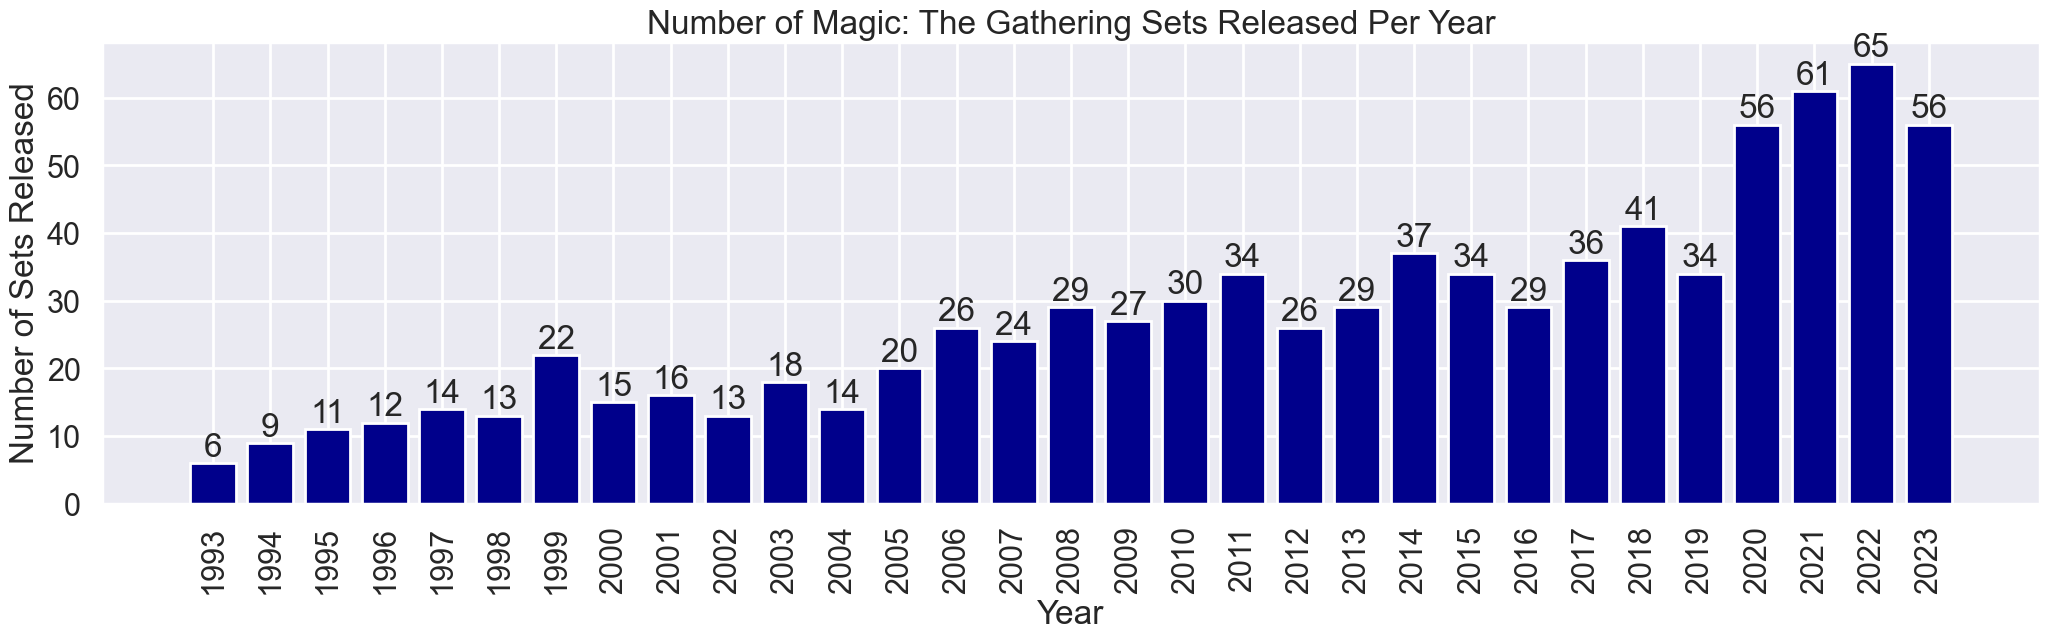

In [22]:
df['year'] = df['released_at'].dt.year  # Extract year from 'released_at'

# Count unique sets per year
sets_per_year = df.groupby('year')['set_name'].nunique().reset_index()

# Rename columns for clarity
sets_per_year.columns = ['Year', 'Number of Sets Released']

# Create a bar chart
plt.figure(figsize=(25,6))  # Set the figure size as desired
plt.bar(sets_per_year['Year'], sets_per_year['Number of Sets Released'], color='darkblue')  # Choose your color

# Add some labels and a title
plt.xlabel('Year')
plt.ylabel('Number of Sets Released')
plt.title('Number of Magic: The Gathering Sets Released Per Year')

# Set x-axis ticks to show every year label
plt.xticks(sets_per_year['Year'], rotation=90)  # Rotate labels to avoid overlap if necessary


# Optionally, add text labels above the bars
for i, val in enumerate(sets_per_year['Number of Sets Released']):
    plt.text(sets_per_year['Year'][i], val, str(val), ha='center', va='bottom')

# Show the plot
plt.show()
